In [2]:
import sagemaker
from sagemaker import get_execution_role
import torch
import torch.nn as nn
import torch.functional as f
import torch.optim as optim
import pandas as pd
from torch.utils.data import random_split, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
#Read and split dataset
bucket = 'sagemaker-ann-fyp'
data_key = 'complete_dataset.csv' 
travel_data = 's3://{}/{}'.format(bucket,data_key)

full_dataset = pd.read_csv(travel_data)

dataset_features = ['hod','sourcelong','sourcelat','dstlong','dstlat','distance']
X = full_dataset[dataset_features]
y = full_dataset['mean_travel_time']

train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=0)

train_X = torch.FloatTensor(train_X.values)
test_X = torch.FloatTensor(test_X.values)

train_y = torch.FloatTensor(train_y.values)
test_y = torch.FloatTensor(test_y.values)

print(train_X)

tensor([[ 1.2000e+01, -3.1432e-01,  5.1517e+01, -2.6322e-01,  5.1623e+01,
          1.8053e+04],
        [ 1.5000e+01, -9.4330e-02,  5.1318e+01, -1.0651e-01,  5.1388e+01,
          9.7661e+03],
        [ 1.8000e+01, -4.6590e-02,  5.1419e+01, -1.3372e-01,  5.1398e+01,
          8.8624e+03],
        ...,
        [ 1.3000e+01, -3.1403e-01,  5.1505e+01, -1.9315e-01,  5.1521e+01,
          1.2252e+04],
        [ 7.0000e+00, -2.3532e-01,  5.1397e+01, -2.7983e-01,  5.1389e+01,
          5.5678e+03],
        [ 0.0000e+00, -1.5530e-01,  5.1339e+01, -1.6564e-01,  5.1396e+01,
          7.4586e+03]])


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
#Custom Data loaders
train_data = TensorDataset(train_X,train_y)
test_data = TensorDataset(test_X,test_y)

batch_size = 200

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

#print(next(iter(train_loader)))

In [6]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super(MLP, self).__init__()
        
        assert out_dim==1, 'out_dim must be 1'
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        
        #creating a module list of hidden layers & adding the input layer as 1st layer in the list
        self.hidden_layers = nn.ModuleList([nn.Linear(self.in_dim, self.hidden_dim[0])])
        
        #create a list of hidden layers by pairing hidden layer dims, and a for loop to create layers 
        #depending on given list of dimensions
        hidden_layer_sizes = zip(self.hidden_dim[:-1], self.hidden_dim[1:])
        for (layer_in, layer_out) in hidden_layer_sizes:
            self.hidden_layers.extend([nn.Linear(layer_in, layer_out)])
        #creates the last layer    
        self.output = nn.Linear(self.hidden_dim[-1], self.out_dim)
        
        #self.linear1 = nn.Linear(self.in_dim, self.hidden_dim[0])
        #self.linear2 = nn.Linear(self.hidden_dim[0], self.hidden_dim[1])
        #self.linear3 = nn.Linear(self.hidden_dim[1], self.hidden_dim[2])
        #self.linear4 = nn.Linear(self.hidden_dim[2], self.hidden_dim[3])
        #self.linear5 = nn.Linear(self.hidden_dim[3], self.hidden_dim[4])
        #self.linear6 = nn.Linear(self.hidden_dim[4], self.hidden_dim[5])
        #self.linear7 = nn.Linear(self.hidden_dim[5], self.out_dim)
        self.dropout = nn.Dropout(p = 0.5)
    
    def forward(self, x):
         #a for loop to loop through each layer in the hidden layer module list
        for h_layer in iter(self.hidden_layers):
            x = self.dropout(torch.relu(h_layer(x)))
        
        #x = torch.relu(self.linear1(x))
        #x = torch.relu(self.linear2(x))
        #x = torch.relu(self.linear3(x))
        #x = torch.relu(self.linear4(x))
        #x = torch.relu(self.linear5(x))
        #x = torch.relu(self.linear6(x))
        #x = self.linear7(x)
        x = self.output(x)
        
        x = x.squeeze(1)
        return x

In [7]:
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [8]:
mlp = MLP(train_X.shape[1], [16,12,10,8,6,4], 1).to(device)
optimizer = optim.Adam(mlp.parameters())

In [10]:
#early stopping
early_stopping = True
tol = 0.0001
patience = 10

#training phase
epochs = 1000
start_time = time.time()

#to plot loss curve after training
train_losses = []
valid_losses = []
early_stop_epochs = 0

for epoch in range(epochs):
    train_loss = 0
    start_time = time.time()
    mlp.train()
    #num_batch = train_X.shape[0] // 200 + 1
    num_batch = len(train_loader)
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        y_pred = mlp(batch_x)

        loss = mae_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min
        
        train_loss += loss.item()

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id+1, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = train_y.shape[0] // 200 + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(test_loader):
    
        y_pred = mlp(batch_x)
        loss = mae_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    #valid_loss /= num_batch
    #valid_losses.append(valid_loss)
    valid_loss /= len(test_loader)
    valid_losses.append(valid_loss)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp_timePrediction_pytorch.model')  
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

    #early stopping
    if early_stopping and epoch > 0:
        if np.abs(valid_losses[-1] - valid_losses[-2]) < tol:
            early_stop_epochs += 1
        else:
            early_stop_epochs = 0
        if early_stop_epochs == patience:
            print("Validation loss has not changed more than {} for {} epochs. Stopping...".format(tol, patience))
            break
    
runtime = time.time() - start_time

print("Total Runtime Elapsed: {:.0f} hours {:.0f} minutes {:.2f} seconds.".format(runtime//3600, runtime%3600//60, runtime%3600%60))

Epoch:1 Batch:562/562 Loss:1774.4160 Time:0m2.46s
Valid Loss:1682.9467
Epoch:2 Batch:562/562 Loss:1798.2843 Time:0m3.62s
Valid Loss:1682.2206
Epoch:3 Batch:562/562 Loss:1725.0315 Time:0m3.13s
Valid Loss:1681.1531
Epoch:4 Batch:562/562 Loss:1593.7145 Time:0m3.81s
Valid Loss:1494.8391
Epoch:5 Batch:562/562 Loss:1215.7323 Time:0m3.88s
Valid Loss:1243.7571
Epoch:6 Batch:562/562 Loss:1371.2534 Time:0m3.79s
Valid Loss:1353.4781
Epoch:7 Batch:562/562 Loss:1216.4010 Time:0m3.95s
Valid Loss:1367.0447
Epoch:8 Batch:562/562 Loss:1086.9181 Time:0m3.24s
Valid Loss:1363.4185
Epoch:9 Batch:562/562 Loss:1301.5868 Time:0m3.99s
Valid Loss:1342.8912
Epoch:10 Batch:562/562 Loss:1246.9731 Time:0m3.59s
Valid Loss:1312.1106
Epoch:11 Batch:562/562 Loss:1159.3779 Time:0m2.28s
Valid Loss:1317.2246
Epoch:12 Batch:562/562 Loss:1137.2001 Time:0m3.56s
Valid Loss:1375.8609
Epoch:13 Batch:562/562 Loss:1218.8854 Time:0m3.92s
Valid Loss:1353.7248
Epoch:14 Batch:562/562 Loss:1301.4902 Time:0m2.98s
Valid Loss:1351.2184
E

KeyboardInterrupt: 

Minimum Validation Loss is 1243.7571
Best iteration: 5


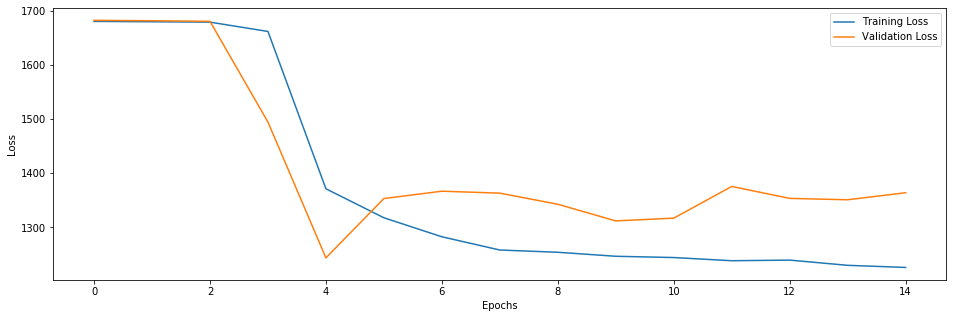

In [11]:
#plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc = 0)

print('Minimum Validation Loss is {:.4f}'.format(min(valid_losses)))
print("Best iteration: {}".format(np.argmin(valid_losses) + 1))

#plt.ylim(0,max(valid_losses)+0.02)
#plt.plot(valid_losses)
#print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

In [10]:
x_test = np.array([[6,0.031180191,51.51122955,-0.044059634,51.54066292,9681]])
input_test = torch.tensor(x_test, dtype=torch.float, device=device )

mlp.load_state_dict(torch.load('mlp_timePrediction_pytorch.model'))
y_pred = mlp(input_test)
y_pred = y_pred.data.cpu().numpy()
print(y_pred)
#Expected reading should be 911.37

[1189.8688]


# Deploy Model

In [ ]:
time_prediction = prediction_model.deploy(initial_count = 1, instance_type="ml.m4.xlarge"); 